## Plots
### Author: Xiang Li



In [1]:
import numpy as np
import pandas as pd
import os

def Add_common_header(df,common_header):
    name_list=[common_header]*len(df.columns)
    tuples = list(zip(name_list,df.columns))
    df.columns = pd.MultiIndex.from_tuples(tuples)
    return df


def DIR_CHECK_CREATE(Input_Path):
    if (not os.path.isdir(Input_Path)):
        print ("New Dir Made is" + Input_Path)
        os.mkdir(Input_Path)
    else: 
        print ('Dir Exists')

# Plot Package
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline
from pybedtools import BedTool

In [6]:
np.log2(1.3)

0.37851162325372983

In [ ]:
#df_gene_expression=generate_All_Genes(path_of_expression,0)
genelist_set=['Myb','Pou2af1','Vipr1','Nsg2','Lef1','Neat1','Eomes','Dapl1','Kif1b','Pipc','Nr4a3','Tet1','Id2','Id3','Gzma','Gzmb','Csf1','Cd7',
              'Ccl5','Ctla4','Fasl','IL2ra','Prdm1','D8Ertd82e']
df_genelist_set=pd.DataFrame({'gene_id':genelist_set})
df_gene_expression = df_gene_expression.merge(df_genelist_set, on='gene_id', how='inner')

#genelist_set

In [2]:
def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')
def gene_associated_multi_feature(gene_annotation_path, feature_path, feature_RPKM_path, expression_path, genelist_set_for_plot):
    ## Genes 
    gene_annotation_Bed=BedTool(gene_annotation_path).sort()
    ## Features To be associated
    features_Bed=BedTool(feature_path).sort()
    ## Associated Rule report ties
    features_associated=features_Bed.closest(gene_annotation_Bed, t='all')
    df_features_associated=pd.read_table(features_associated.fn, header=None)
    ## Group by gene_id
    df_genes_with_features=df_features_associated.groupby(7) ## in some cases, 7 columns is gene_id
    ## add expression
    df_gene_expression=generate_All_Genes(path_of_expression,0)
    ### in here, feature coordinates are seperate file from RPKM
    df_edgeR=pd.read_csv(feature_RPKM_path, sep='\t')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
    
    j=0
    for gene_set_name in genelist_set.keys():
        print gene_set_name
        df_genelist_set=pd.DataFrame({'gene_id':genelist_set[gene_set_name]})
        df_gene_expression_tem=df_gene_expression.merge(df_genelist_set, on='gene_id', how='inner')
        i=0
        for genelist in df_gene_expression_tem.sort_values('log2(fold_change)')['gene_id']:
            if(genelist not in df_features_associated[7].unique()):
                continue
            group=df_genes_with_features.get_group(genelist)
            gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID'})[['GeneID']], on='GeneID',how='inner').sort_values('logFC')


            x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
            y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
            gene_expression_fc = df_gene_expression[df_gene_expression['gene_id']==genelist]['log2(fold_change)'].values[0]
            im=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc, c=gene_associated_DNase['logFC'],
                        vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='v')
            #ax.text(i,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
            i+=1
        ax.text(len(genelist_set[genelist_set.keys()[j]])/2, gene_expression_fc-1, 'Genelists: '+ str(len(genelist_set[genelist_set.keys()[j]])), fontsize=12, color='r')   
        j+=1
    ax.plot(np.arange(i),np.zeros(i), '--', linewidth=1)
    ax.set_ylabel('Expression  Log$_2$FC', fontsize='18')
    ax.legend([im], ['DNase_Site'], scatterpoints=1,loc=0, fontsize=14)
    fig.colorbar(im,ax=ax)
    return df_gene_expression.sort_values('log2(fold_change)')['gene_id']

def gene_associated_multi_feature_tcf1(gene_annotation_path, feature_path, feature_RPKM_path, tcf1_feature_path, expression_path, genelist_set_for_plot):
    ## Genes 
    gene_annotation_Bed=BedTool(gene_annotation_path).sort()
    ## Features To be associated
    features_Bed=BedTool(feature_path).sort()
    ## Add Tcf1
    Tcf1_Peak_Bed=BedTool(tcf1_feature_path)
    features_Bed_with_Tcf1=features_Bed.intersect(Tcf1_Peak_Bed,c=True)
    ## Associated Rule report ties
    features_associated=features_Bed_with_Tcf1.closest(gene_annotation_Bed, t='all')
    df_features_associated=pd.read_table(features_associated.fn, header=None)
    ## Group by gene_id
    df_genes_with_features=df_features_associated.groupby(8) ## in some cases, 7 columns is gene_id
    ## add expression
    df_gene_expression=generate_All_Genes(path_of_expression,0)
    ### in here, feature coordinates are seperate file from RPKM
    df_edgeR=pd.read_csv(feature_RPKM_path, sep='\t')
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))
    
    j=0
    for gene_set_name in genelist_set.keys():
        print gene_set_name
        df_genelist_set=pd.DataFrame({'gene_id':genelist_set[gene_set_name]})
        df_gene_expression_tem=df_gene_expression.merge(df_genelist_set, on='gene_id', how='inner')
        i=0
        for genelist in df_gene_expression_tem.sort_values('log2(fold_change)')['gene_id']:
            if(genelist not in df_features_associated[8].unique()):
                continue
            group=df_genes_with_features.get_group(genelist)
            gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID', 4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')


            x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
            y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
            gene_expression_fc = df_gene_expression[df_gene_expression['gene_id']==genelist]['log2(fold_change)'].values[0]
            im=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc,
                          c=gene_associated_DNase['logFC'],
                        vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
            im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
                vmin=-1,vmax=1,s=5, cmap='bwr', marker='X')
            ax.text(i,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
            i+=1
        ax.text(len(genelist_set[genelist_set.keys()[j]])/2, gene_expression_fc-1, 'Genelists: '+ str(len(genelist_set[genelist_set.keys()[j]])), fontsize=12, color='r')   
        j+=1
    im_zero = ax.plot(np.arange(i),np.zeros(i), '--', linewidth=1)
    ax.set_ylabel('Expression  Log$_2$FC', fontsize='18')
    ax.legend([im,im_Tcf1], ['DNase_Site','Tcf1_Binding'], scatterpoints=1,loc=0, fontsize=14)
    fig.colorbar(im,ax=ax)
    return df_features_associated

Haihui_part1


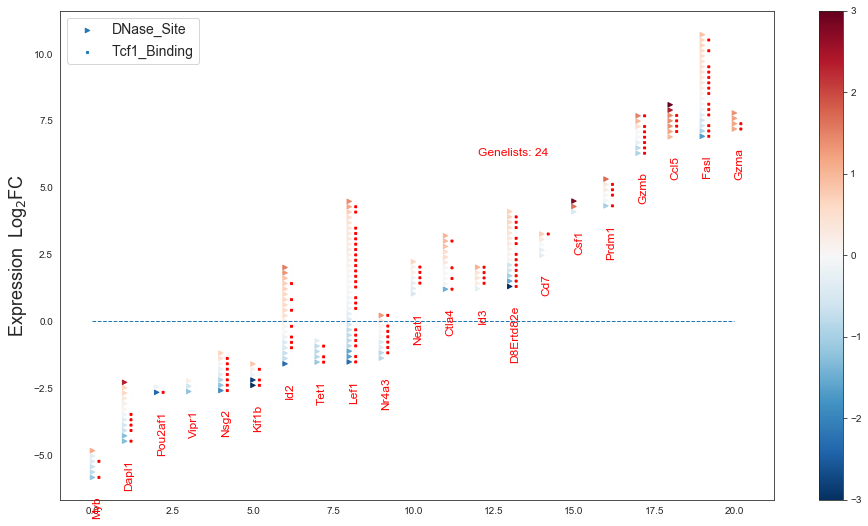

In [530]:
genelist_set={'Haihui_part1':['Myb','Pou2af1','Vipr1','Nsg2','Lef1','Neat1','Eomes','Dapl1','Kif1b','Pipc','Nr4a3','Tet1','Id2','Id3','Gzma','Gzmb','Csf1','Cd7',
              'Ccl5','Ctla4','Fasl','IL2ra','Prdm1','D8Ertd82e']}

gene_annotation_path='/home/lxiang/cloud_research/PengGroup/XLi/Annotation/UCSC/Mouse_Genome/gene_iv/mm9/gene_Genebody_Up_EX_50k_unique.bed'
Tcf1_Peak_path='WT_CD8_TCF1_22286_filtered_peask_19042.bed'
feature_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/36380_Union_DNase_Peaks_10_Reps.bedpe'
expression_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/Cuffdiff_Results/DKO_0h_vs_WT_0h'
feature_RPKM_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/diff_DNase_dKO-na_WT-na.txt'


test=gene_associated_multi_feature_tcf1(gene_annotation_path, feature_path, feature_RPKM_path, Tcf1_Peak_path, expression_path, genelist_set)


In [350]:
gene_list=['myb']
#gene_annotation=BedTool('/home/lxiang/cloud_research/PengGroup/XLi/Annotation/gtf_files/2015_GTF/mm9_genes_with_stand.bed')
#gene_annotation=BedTool('/home/lxiang/cloud_research/PengGroup/XLi/Annotation/UCSC/Mouse_Genome/gene_iv/mm9/gene_TSS_iv_unique_lx.bed')
gene_annotation=BedTool('/home/lxiang/cloud_research/PengGroup/XLi/Annotation/UCSC/Mouse_Genome/gene_iv/mm9/gene_Genebody_Up_EX_50k_unique.bed')


gene_annotation=gene_annotation.sort()
DNase_Peak=BedTool('36380_Union_DNase_Peaks_10_Reps.bedpe')
DNase_Peak=DNase_Peak.sort()
Tcf1_Peak=BedTool('WT_CD8_TCF1_22286_filtered_peask_19042.bed')
DNase_Peak_with_Tcf1=DNase_Peak.intersect(Tcf1_Peak,c=True)

test=DNase_Peak_with_Tcf1.closest(gene_annotation, t='all')
df_test=pd.read_table(test.fn, header=None)

df_test_groups = df_test.groupby(8)
#print (len(df_test))

In [354]:
#df_up_genelist_30[df_up_genelist_30['gene_id']==genelist]['log2(fold_change)']

In [ ]:
###   feature associated with genes test step by step
###

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,12))
num=70

i=0
df_up_genelist=pd.read_csv('d_up_DKO_0h_vs_WT_0h.bed', sep='\t').nlargest(313,'log2(fold_change)')
#df_up_genelist_30=generate_All_Genes(path_of_expression,0)
df_edgeR=pd.read_csv('diff_DNase_dKO-na_WT-na.txt', sep='\t')
genelist_set=df_up_genelist['gene_id'].values
#genelist_set=['Myb','Pou2af1','Vipr1','Nsg2','Lef1','Neat1','Eomes','Dapl1','Kif1b','Pipc','Nr4a3','Tet1','Id2','Id3','Gzma','Gzmb','Csf1','Cd7',
#              'Ccl5','Ctla4','Fasl','IL2ra','Prdm1','D8Ertd82e']

#genelist_set=genelist_for_haihui
for genelist in genelist_set:
    if(genelist not in df_test[8].unique()):
        continue
    group=df_test_groups.get_group(genelist)
    gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID',4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')
    #gene_associated_DNase['logFC']
    x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
    y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
    gene_expression_fc = df_up_genelist[df_up_genelist['gene_id']==genelist]['log2(fold_change)'].values[0]
    im_DNase=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc, c=gene_associated_DNase['logFC'],
                vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
    #im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
    #            vmin=-1,vmax=1,s=5, cmap='bwr', marker='X')
    #ax.text(i-0.1,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
    i+=1
#gene_associated_DNase
#group.rename(columns={3:'GeneID'})['GeneID']

i=0
df_down_genelist=pd.read_csv('d_down_DKO_0h_vs_WT_0h.bed', sep='\t').nsmallest(259,'log2(fold_change)')

df_edgeR=pd.read_csv('diff_DNase_dKO-na_WT-na.txt', sep='\t')
#genelist_set=['Myb','Lef1']
genelist_set=df_down_genelist['gene_id']
for genelist in genelist_set:
    if(genelist not in df_test[8].unique()):
        continue
    group=df_test_groups.get_group(genelist)
    gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID',4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')
    #gene_associated_DNase['logFC']
    x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
    y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
    gene_expression_fc = df_down_genelist[df_down_genelist['gene_id']==genelist]['log2(fold_change)'].values[0]
    im_DNase=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc , c=gene_associated_DNase['logFC'],
                vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
    #im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
    #            vmin=-1,vmax=1,s=5, cmap='bwr', marker='x')
    #ax.text(i-0.1,gene_expression_fc-1, genelist, fontsize=11, color='b', rotation=90)

    #plt.annotate(genelist, color='b', fontsize='14', xy=((x_coordinate+i),(y_coordinate+gene_expression_fc)))
    i+=1

ax.set_xlabel('Up_Regulated_Genes: '+ str(len(df_up_genelist['gene_id'].values)) + 'Down_Regulated_Genes: '
              +str(len(df_down_genelist['gene_id'].values)), fontsize='18')
ax.set_ylabel('Expression  Log$_2$FC', fontsize='18')
#group.rename(columns={3:'GeneID'})['GeneID']
fig.colorbar(im_DNase,ax=ax)
ax.legend((im_DNase,im_Tcf1), ('DNase_Site','Tcf1_Binding'),
          scatterpoints=1,loc=0, fontsize=14)
#fig.colorbar(im_Tcf1,ax=ax)

# Venn 2, 3 and 4

In [3]:
def Generate_Venn_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn2
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 2:
        print ('Input Two, Continue.')
        PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')

        ### Union A and B, use indicator to differentiate them.
        union_A_B=df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer', indicator=True)

        intersection_A_B=union_A_B[union_A_B['_merge']=='both']
        only_A=union_A_B[union_A_B['_merge']=='left_only']
        only_B=union_A_B[union_A_B['_merge']=='right_only']

        #Output
        intersection_A_B.to_csv(OUT_PATH+'/Intersection_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_A.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[0][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        only_B.to_csv(OUT_PATH+'/Only_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
        union_A_B.to_csv(OUT_PATH+'/Union_'+INPUT_LIST[0][:-4]+'_'+INPUT_LIST[1][:-4]+FILE_TYPE,index=None, columns=[Merge_Column])
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')


    out = venn2(subsets=(len(only_A[Merge_Column]), len(only_B[Merge_Column]), len(intersection_A_B[Merge_Column])),
          set_labels=(INPUT_LIST[0][:-4], INPUT_LIST[1][:-4] ) )
    for text in out.subset_labels:
        text.set_fontsize(18)
    plt.show()
    
def Generate_Venn3_Diagram(Raw_Path, Out_Path, Merge_Column):
    from matplotlib_venn import venn3, venn3_circles
    
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST=os.listdir(RAW_PATH)
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 3:
        print ('Input Three, Continue.')
        PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
        PATH_B = RAW_PATH + '/' +INPUT_LIST[1]
        PATH_C = RAW_PATH + '/' +INPUT_LIST[2]

        ConA=INPUT_LIST[0][:-4]
        ConB=INPUT_LIST[1][:-4]
        ConC=INPUT_LIST[2][:-4]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')
        df_C = pd.read_csv(PATH_C,sep='\t')

        Merge_Column='gene_id'

        union_A_B_C = df_C.loc[:, [Merge_Column]].merge( df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer'), how='outer')

        intersection_metrix=np.zeros( (len(union_A_B_C),3), dtype=int)


        for j in range(len(union_A_B_C)):
            if (union_A_B_C.loc[j,'gene_id'] in df_A.loc[:,'gene_id']):
                intersection_metrix[j,0] == 1
            if (union_A_B_C.loc[j,'gene_id'] in df_B.loc[:,'gene_id']):
                intersection_metrix[j,1] == 1
            if (union_A_B_C.loc[j,'gene_id'] in df_C.loc[:,'gene_id']):
                intersection_metrix[j,2] == 1

        intersection_metrix = pd.DataFrame(union_A_B_C['gene_id'].isin(df_A['gene_id']))
        intersection_metrix = pd.concat([intersection_metrix.rename(columns={'gene_id':ConA}),union_A_B_C['gene_id'].isin(df_B['gene_id'])], axis=1, join='inner')
        intersection_metrix = pd.concat([intersection_metrix.rename(columns={'gene_id':ConB}),union_A_B_C['gene_id'].isin(df_C['gene_id'])], axis=1, join='inner')
        intersection_metrix = intersection_metrix.rename(columns={'gene_id':ConC})

        intersection_metrix = intersection_metrix*1


        intersection_metrix ['ABC'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,1]+intersection_metrix.iloc[:,2]
        intersection_metrix ['AB'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,1]
        intersection_metrix ['AC'] = intersection_metrix.iloc[:,0]+intersection_metrix.iloc[:,2]
        intersection_metrix ['BC'] = intersection_metrix.iloc[:,1]+intersection_metrix.iloc[:,2]
        #intersection_metrix
        ABC = len(intersection_metrix[intersection_metrix['ABC']==3])
        AB = len(intersection_metrix[intersection_metrix['AB']==2])   -ABC
        BC = len(intersection_metrix[(intersection_metrix['BC']==2)]) -ABC
        AC = len(intersection_metrix[(intersection_metrix['AC']==2)]) -ABC

        A_solo = len(df_A) - ABC - AC - AB 
        B_solo = len(df_B) - ABC - BC - AB 
        C_solo = len(df_C) - ABC - AC - BC
        print (A_solo, B_solo, AB, C_solo, AC, BC, ABC)
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')
        
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(8,8))
    out = venn3(subsets = (A_solo, B_solo, AB, C_solo, AC, BC, ABC), set_labels = (ConA, ConB, ConC))
    for text in out.subset_labels:
        if text == None:
            continue
        text.set_fontsize(18)
        
def Generate_Venn4_Diagram(Raw_Path, Out_Path, Merge_Column):
    import venn
    DIR_CHECK_CREATE(Raw_Path)
    DIR_CHECK_CREATE(Out_Path)
    Merge_Column='gene_id'
    
    INPUT_LIST = [f for f in os.listdir(Raw_Path) if not f.startswith('.')]
    INPUT_LIST.sort()
    
    FILE_TYPE=INPUT_LIST[0][-4:]
    print('Input File: ' )
    print(INPUT_LIST)
    
    if len(INPUT_LIST) == 4:
        print ('Input Three, Continue.')
        PATH_A = Raw_Path + '/' +INPUT_LIST[0]
        PATH_B = Raw_Path + '/' +INPUT_LIST[1]
        PATH_C = Raw_Path + '/' +INPUT_LIST[2]
        PATH_D = Raw_Path + '/' +INPUT_LIST[3]

        ConA=INPUT_LIST[0][:-4]
        ConB=INPUT_LIST[1][:-4]
        ConC=INPUT_LIST[2][:-4]
        ConD=INPUT_LIST[3][:-4]

        df_A = pd.read_csv(PATH_A,sep='\t')
        df_B = pd.read_csv(PATH_B,sep='\t')
        df_C = pd.read_csv(PATH_C,sep='\t')
        df_D = pd.read_csv(PATH_D,sep='\t')

        union_ABCD = df_D.loc[:,[Merge_Column]].merge( df_C.loc[:, [Merge_Column]].merge( df_A.loc[:, [Merge_Column]].merge(df_B.loc[:,[Merge_Column]], how='outer'), how='outer'), how='outer')

        
        intersection_metrix = pd.DataFrame({ConA:union_ABCD['gene_id'].isin(df_A['gene_id']),
                                ConB:union_ABCD['gene_id'].isin(df_B['gene_id']),
                                ConC:union_ABCD['gene_id'].isin(df_C['gene_id']),
                                ConD:union_ABCD['gene_id'].isin(df_D['gene_id']), 'gene_id':union_ABCD['gene_id']})
        intersection_metrix = intersection_metrix.set_index('gene_id')*1
        
        
        
        intersection_metrix ['ABCD'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConB]+intersection_metrix.loc[:,ConC]+intersection_metrix.loc[:,ConD]
        
        intersection_metrix ['ABC'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConB]+intersection_metrix.loc[:,ConC]
        intersection_metrix ['ABD'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConB]+intersection_metrix.loc[:,ConD]
        intersection_metrix ['ACD'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConC]+intersection_metrix.loc[:,ConD]   
        intersection_metrix ['BCD'] = intersection_metrix.loc[:,ConB]+intersection_metrix.loc[:,ConC]+intersection_metrix.loc[:,ConD]
        
        intersection_metrix ['AB'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConB]
        intersection_metrix ['AC'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConC]
        intersection_metrix ['AD'] = intersection_metrix.loc[:,ConA]+intersection_metrix.loc[:,ConD]
        intersection_metrix ['BC'] = intersection_metrix.loc[:,ConB]+intersection_metrix.loc[:,ConC]
        intersection_metrix ['BD'] = intersection_metrix.loc[:,ConB]+intersection_metrix.loc[:,ConD]
        intersection_metrix ['CD'] = intersection_metrix.loc[:,ConD]+intersection_metrix.loc[:,ConC]
        
        
        
        #intersection_metrix
        ABCD = len(intersection_metrix[intersection_metrix['ABCD']==4])
        
        ABC = len(intersection_metrix[intersection_metrix['ABC']==3])-ABCD
        ABD = len(intersection_metrix[intersection_metrix['ABD']==3])-ABCD
        ACD = len(intersection_metrix[intersection_metrix['ACD']==3])-ABCD
        BCD = len(intersection_metrix[intersection_metrix['BCD']==3])-ABCD
        
        AB = len(intersection_metrix[intersection_metrix['AB']==2])   -ABC-ABD-ABCD
        AC = len(intersection_metrix[(intersection_metrix['AC']==2)]) -ABC-ACD-ABCD
        AD = len(intersection_metrix[intersection_metrix['AD']==2])   -ABD-ACD-ABCD
        BC = len(intersection_metrix[(intersection_metrix['BC']==2)]) -ABC-BCD-ABCD
        BD = len(intersection_metrix[(intersection_metrix['BD']==2)]) -ABD-BCD-ABCD
        CD = len(intersection_metrix[(intersection_metrix['CD']==2)]) -ACD-BCD-ABCD

        A_solo = len(df_A) - ABCD - ABC - ABD - ACD - AB - AC - AD
        B_solo = len(df_B) - ABCD - ABC - ABD - BCD - AB - BC - BD
        C_solo = len(df_C) - ABCD - ABC - ACD - BCD - AC - BC - CD
        D_solo = len(df_D) - ABCD - ABD - ACD - BCD - AD - BD - CD
        print (A_solo, B_solo, AB, C_solo, AC, BC, ABC)
    else:
        print('Error!')
        print('Input '+str(len(INPUT_LIST))+ ' Files')
        
    labels = venn.get_labels([{0},{0},{0},{0}],  fill=['number'])
    labels['1111'] = ABCD
    labels['1110'] = ABC
    labels['1101'] = ABD
    labels['1011'] = ACD
    labels['0111'] = BCD
    labels['1100'] = AB
    labels['1010'] = AC
    labels['1001'] = AD
    labels['0110'] = BC
    labels['0101'] = BD
    labels['0011'] = CD
    labels['1000'] = A_solo
    labels['0001'] = D_solo
    labels['0010'] = C_solo
    labels['0100'] = B_solo

    fig, ax = venn.venn4(labels, names=[ConA, ConB, ConC, ConD], figsize=(9,8))
    fig.show()
    
    #        Atlantic  Indian
    #whales     8        2
    #sharks     1        5
    #oddsratio, pvalue = stats.fisher_exact([[8, 2], [1, 5]])

    
    import scipy.stats as stats
    oddsratio, pvalue = stats.fisher_exact([[AC,AD],[BC,BD]])
    ax.set_title('Pvalue = '+ str( "%.4g" % pvalue), fontsize=28)
    return intersection_metrix

In [207]:
def generate_genes_FPKM_df(Input_Path):
    df = pd.read_csv(Input_Path+'/genes.read_group_tracking', sep='\t', header=0)
    FPKM_df = None
    for cond in df['condition'].unique():
        for replica in df[df['condition'] == cond]['replicate'].unique():
            #print (cond, replica)
            temp_df = (df[ (df['condition'] == cond) & (df['replicate'] == replica)].loc[:,['tracking_id', 'FPKM']])
            cond_name= cond+'_'+str(replica)
            temp_df.rename(columns={'tracking_id': 'gene_id', 'FPKM': cond_name }, inplace=True)
            if FPKM_df is None:
                FPKM_df
                FPKM_df = temp_df  
            else:
                FPKM_df = FPKM_df.merge(temp_df, on='gene_id', how='outer', suffixes=('','_'))
    return FPKM_df

def generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')

In [8]:
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact([[92,213],[184,47]])
print "%.4g" % pvalue

4.374e-31


Dir Exists
Dir Exists
Input File: 
['a_1191_up_DKO_0h_vs_WT_0h.csv', 'b_1368_down_DKO_0h_vs_WT_0h_fc1.3.csv', 'c_1542_DNase_Lost_Site.bed', 'd_1072_DNase_Newly_Acquired_Site.bed']
Input Three, Continue.
(898, 1088, 0, 1122, 92, 213, 0)


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


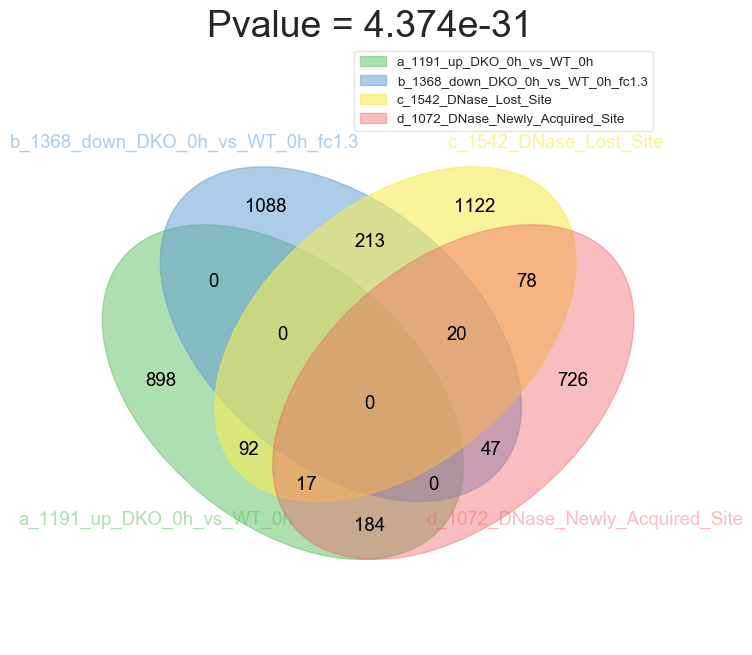

In [287]:
Venn4_Path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/Venn4_WT_na_dKO_na/'
Out_Path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/'
union_ABCD=Generate_Venn4_Diagram(Venn4_Path, Out_Path,'gene_id')

In [470]:
print len(union_ABCD[(union_ABCD['AC']==2) & ((union_ABCD['ABCD']==2))])
genelist_92=union_ABCD[(union_ABCD['AC']==2) & ((union_ABCD['ABCD']==2))].index.values
print len(union_ABCD[(union_ABCD['BC']==2) & ((union_ABCD['ABCD']==2))].index.values)
genelist_213=union_ABCD[(union_ABCD['BC']==2) & ((union_ABCD['ABCD']==2))].index.values
print len(union_ABCD[(union_ABCD['AD']==2) & ((union_ABCD['ABCD']==2))])
genelist_184=union_ABCD[(union_ABCD['AD']==2) & ((union_ABCD['ABCD']==2))].index.values
print len(union_ABCD[(union_ABCD['BD']==2) & ((union_ABCD['ABCD']==2))].index.values)
genelist_47=union_ABCD[(union_ABCD['BD']==2) & ((union_ABCD['ABCD']==2))].index.values

92
213
184
47


gene_92
gene_213


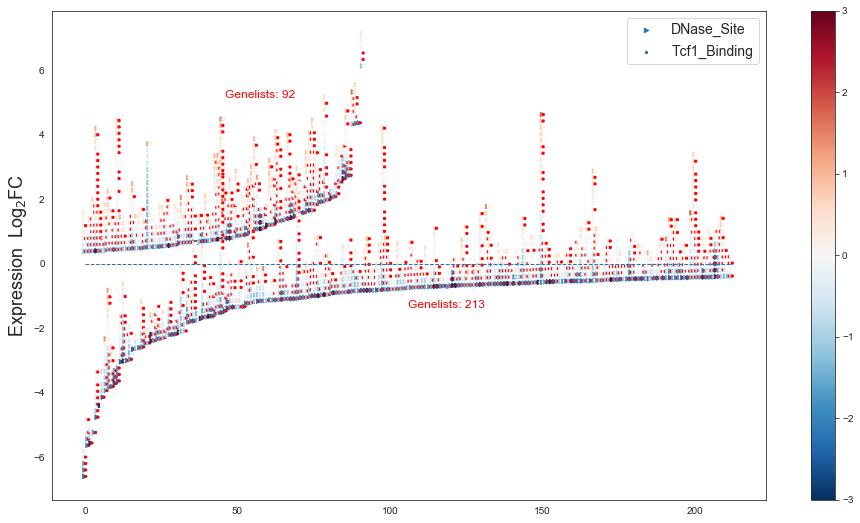

In [526]:
gene_annotation_path='/home/lxiang/cloud_research/PengGroup/XLi/Annotation/UCSC/Mouse_Genome/gene_iv/mm9/gene_Genebody_Up_EX_50k_unique.bed'
Tcf1_Peak_path='WT_CD8_TCF1_22286_filtered_peask_19042.bed'
feature_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/36380_Union_DNase_Peaks_10_Reps.bedpe'
expression_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/Cuffdiff_Results/DKO_0h_vs_WT_0h'
feature_RPKM_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/diff_DNase_dKO-na_WT-na.txt'

genelist_set={'gene_92':genelist_92, 'gene_213':genelist_213}

test=gene_associated_multi_feature_tcf1(gene_annotation_path, feature_path, feature_RPKM_path, Tcf1_Peak_path, path_of_expression, genelist_set)


Text(0.5,0,'Up_Regulated_Genes: 184Down_Regulated_Genes: 213')

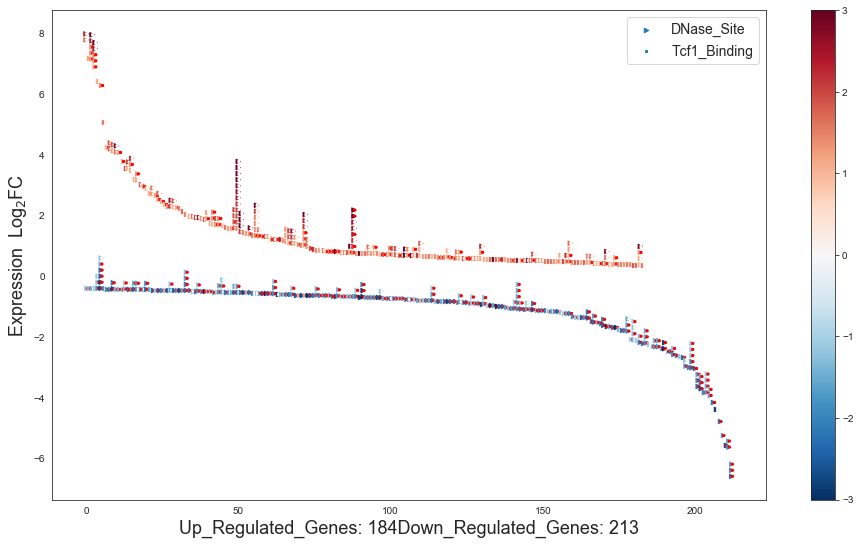

In [507]:
gene_annotation=BedTool(gene_annotation_path)
gene_annotation=gene_annotation.sort()
DNase_Peak=BedTool('36380_Union_DNase_Peaks_10_Reps.bedpe')
DNase_Peak=DNase_Peak.sort()
Tcf1_Peak=BedTool('WT_CD8_TCF1_22286_filtered_peask_19042.bed')
DNase_Peak_with_Tcf1=DNase_Peak.intersect(Tcf1_Peak,c=True)


feature_RPKM_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/1334_Lost_DNase_Sites.csv'
test=DNase_Peak_with_Tcf1.closest(gene_annotation, t='all')
df_test=pd.read_table(test.fn, header=None)

df_test_groups = df_test.groupby(8)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,9))

i=0

df_edgeR=pd.read_csv(feature_RPKM_path, sep='\t')
genelist_set=pd.DataFrame({'gene_id':genelist_213})


df_gene_expression=generate_All_Genes(path_of_expression,0)
df_gene_expression=df_gene_expression.merge(genelist_set, on='gene_id', how='inner').sort_values('log2(fold_change)', ascending=False)

for genelist in df_gene_expression['gene_id'].values:
    if(genelist not in df_test[8].unique()):
        continue
    group=df_test_groups.get_group(genelist)
    gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID',4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')
    #gene_associated_DNase['logFC']
    x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
    y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
    gene_expression_fc = df_gene_expression[df_gene_expression['gene_id']==genelist]['log2(fold_change)'].values[0]
    im_DNase=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc, c=gene_associated_DNase['logFC'],
                vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
    im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
                vmin=-1,vmax=1,s=5, cmap='bwr', marker='X')
    #ax.text(i-0.1,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
    i+=1


    
i=0

feature_RPKM_path='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNaseq_seq_RNA_Seq/Diff_Binding_Events_Dnaseq/Diff_By_edgeR/1150_Gain_DNase_Sites.csv'
df_edgeR=pd.read_csv(feature_RPKM_path, sep='\t')
genelist_set=pd.DataFrame({'gene_id':genelist_184})


df_gene_expression=generate_All_Genes(path_of_expression,0)
df_gene_expression=df_gene_expression.merge(genelist_set, on='gene_id', how='inner').sort_values('log2(fold_change)', ascending=False)

for genelist in df_gene_expression['gene_id'].values:
    if(genelist not in df_test[8].unique()):
        continue
    group=df_test_groups.get_group(genelist)
    gene_associated_DNase=df_edgeR.merge(group.rename(columns={3:'GeneID',4:'Tcf1'})[['GeneID','Tcf1']], on='GeneID',how='inner').sort_values('logFC')
    #gene_associated_DNase['logFC']
    x_coordinate=np.zeros(len(gene_associated_DNase['logFC']))
    y_coordinate=np.arange(len(gene_associated_DNase['logFC']))/5.0
    gene_expression_fc = df_gene_expression[df_gene_expression['gene_id']==genelist]['log2(fold_change)'].values[0]
    im_DNase=ax.scatter(x_coordinate+i, y_coordinate+gene_expression_fc, c=gene_associated_DNase['logFC'],
                vmin=-3,vmax=3,s=20, cmap='RdBu_r', marker='>')
    im_Tcf1=ax.scatter(x_coordinate+i+0.2, y_coordinate+gene_expression_fc, c=gene_associated_DNase['Tcf1'],
                vmin=-1,vmax=1,s=5, cmap='bwr', marker='X')
    #ax.text(i-0.1,gene_expression_fc-1, genelist, fontsize=12, color='r', rotation=90)
    i+=1    
  

#ax.set_xlabel('Top and Bottom ' + str(i) + ' of Expression Fold Change', fontsize='18')
ax.set_ylabel('Expression  Log$_2$FC', fontsize='18')
#group.rename(columns={3:'GeneID'})['GeneID']
fig.colorbar(im_DNase,ax=ax)
ax.legend((im_DNase,im_Tcf1), ('DNase_Site','Tcf1_Binding'),
          scatterpoints=1,loc=0, fontsize=14)
#fig.colorbar(im_Tcf1,ax=ax)
ax.set_xlabel('Up_Regulated_Genes: '+ str(184) + 'Down_Regulated_Genes: '
              +str(213), fontsize='18')

In [127]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy import stats


In [157]:
RAW_PATH='/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/Cuffdiff_Results/DKO_0h_vs_WT_0h'
df_FPKM=generate_genes_FPKM_df(RAW_PATH)


df_DNase_Peak=pd.read_csv('36380_Union_DNase_Peaks_10_Reps.bedpe', sep='\t', header=None).rename(columns={3:'GeneID'})
df_edgeR=pd.read_csv('diff_DNase_dKO-na_WT-na.txt', sep='\t')
df_edgeR_UP=df_edgeR [ (df_edgeR['logFC']<np.log2(0.5)) & (df_edgeR['FDR']<=0.05)][['GeneID']]
#df_edgeR_UP=df_edgeR [ (df_edgeR['logFC']>1.0) & (df_edgeR['FDR']<=0.05)][['GeneID']]

df_DNase_Peak_up = df_DNase_Peak.merge(df_edgeR_UP, on='GeneID', how='inner')

DNase_Peak_up = BedTool.from_dataframe(df_DNase_Peak_up)
a=BedTool('gene_Genebody_Up_EX_50k_unique.bed')
DNase_Peak_up_associated_gene=a.intersect(DNase_Peak_up, u=True)
up_genelist=pd.read_table(DNase_Peak_up_associated_gene.fn, header=None).rename(columns={3:'gene_id'})

df_RPKM_up = df_FPKM.merge(up_genelist[['gene_id']],on='gene_id',how='inner').set_index('gene_id')

#x = StandardScaler().fit_transform(df_RPKM_up)

#kmeans = AgglomerativeClustering(n_clusters=3, linkage='ward').fit(stats.zscore(df_RPKM_up, axis=0))
#kmeans = KMeans(n_clusters=3, random_state=0).fit(stats.zscore(df_RPKM_up, axis=0))

#df_RPKM_up['labels']=kmeans.labels_


#df_RPKM_up.to_csv('1542_DNase_Lost_Site.bed',sep='\t',header=True)
#df_RPKM_up.to_csv('1072_DNase_Newly_Acquired_Site.bed',sep='\t',header=True)

(1393, 6)

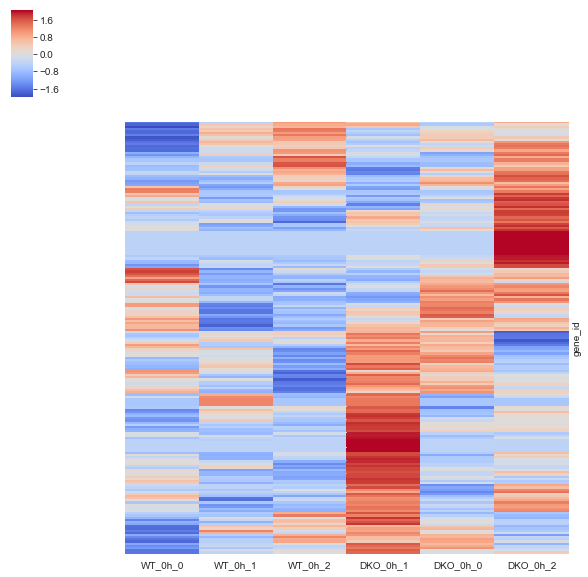

In [178]:
len(fig_1.dendrogram_row.reordered_ind)

index_for_plot = fig_1.dendrogram_row.reordered_ind[0:200]

### Drop all zeros rows for plot
df_ALL_DEGs=df_RPKM_up
Heatmap_Df = df_ALL_DEGs.loc[(df_ALL_DEGs!=0).any(axis=1)]


#### Very Important

#Heatmap_Df=FPKM_df.fillna(0)
# Prepare a vector of color mapped to the 'cyl' column
#my_palette = dict(zip(Heatmap_Df.labels.unique(), ["red","green","blue"]))
#row_colors = Heatmap_Df.labels.map(my_palette)

#Heatmap_Df_plot=Heatmap_Df.drop(labels='labels',axis=1)
#Heatmap_Df_plot = Heatmap_Df_plot.loc[(Heatmap_Df_plot!=0).any(axis=1)]

Heatmap_Name='DNase_Lost_'+str(len(index_for_plot))

fig_1_tem = sns.clustermap(Heatmap_Df.iloc[index_for_plot,:], method="single",yticklabels=False,
z_score=0, col_cluster=False, row_cluster=False, cmap='coolwarm')#, row_colors=row_colors)

#fig_1.savefig(Heatmap_Name+'.png')
fig_1.fig.suptitle(Heatmap_Name)
Heatmap_Df.shape

(1393, 6)

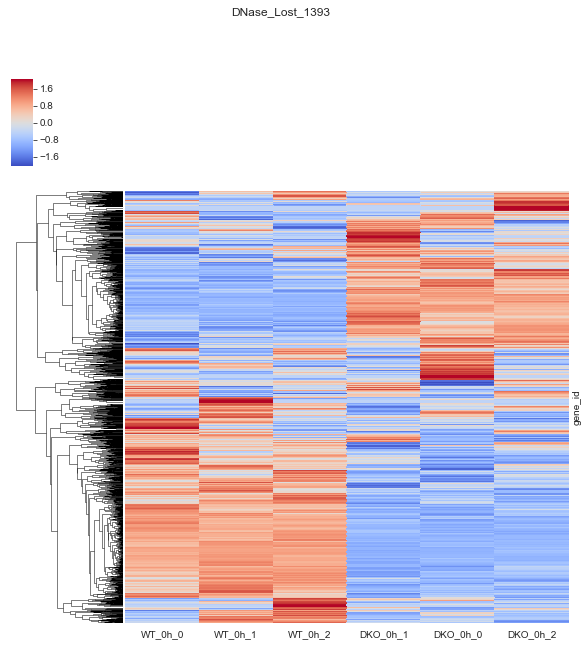

In [177]:
### Drop all zeros rows for plot
df_ALL_DEGs=df_RPKM_up
Heatmap_Df = df_ALL_DEGs.loc[(df_ALL_DEGs!=0).any(axis=1)]


#### Very Important

#Heatmap_Df=FPKM_df.fillna(0)
# Prepare a vector of color mapped to the 'cyl' column
#my_palette = dict(zip(Heatmap_Df.labels.unique(), ["red","green","blue"]))
#row_colors = Heatmap_Df.labels.map(my_palette)

#Heatmap_Df_plot=Heatmap_Df.drop(labels='labels',axis=1)
#Heatmap_Df_plot = Heatmap_Df_plot.loc[(Heatmap_Df_plot!=0).any(axis=1)]

Heatmap_Name='DNase_Lost_'+str(len(Heatmap_Df.index))

fig_1 = sns.clustermap(Heatmap_Df, yticklabels=False,
z_score=0, col_cluster=False, row_cluster=True, cmap='coolwarm')#, row_colors=row_colors)

#fig_1.savefig(Heatmap_Name+'.png')
fig_1.fig.suptitle(Heatmap_Name)
Heatmap_Df.shape

Dir Exists
Dir Exists
Input File: 
['up_DKO_0h_vs_WT_0h.bed', 'Up_DKO_CD8_0h_over_WT_CD8_0h_ZZ.bed']
Input Two, Continue.


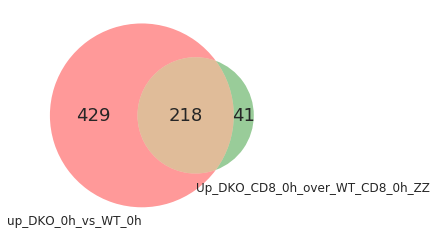

In [14]:
Folder_Name='Up'
RAW_PATH=os.getcwd() + '/Venn_Results_WT_0h_DKO_0h_vs_ZZ_2016/' + Folder_Name
OUT_PATH=os.getcwd() + '/Venn_Results_WT_0h_DKO_0h_vs_ZZ_2016/Results_' + Folder_Name

Generate_Venn_Diagram(RAW_PATH, OUT_PATH, 'gene_id')

# Venn By Coordinates

In [72]:
def Generate_Venn_Diagram(Raw_Path, Out_Path):
    from pybedtools import BedTool
    from matplotlib_venn import venn2
    
    #
    INPUT_LIST = [f for f in os.listdir(Raw_Path) if not f.startswith('.')]  ## Exclude hidden file, start with .
    print INPUT_LIST
    if len(INPUT_LIST) == 2:
        print ('Input Two, Continue.')
        PATH_A = Raw_Path + '/' +INPUT_LIST[0]
        PATH_B = Raw_Path + '/' +INPUT_LIST[1]

    df1 = BedTool(PATH_A)
    df2 = BedTool(PATH_B)


    intersect_df = df1.intersect(df2, u=True)

    out = venn2(subsets=(len(df1-df2), len(df2-df1), len(df2+df1)),
              set_labels=(len(df1), len(df2)))
    for text in out.subset_labels:
        text.set_fontsize(14)

    (df1-df2).saveas(str(len(df1-df2))+'_specific_'+INPUT_LIST[0][0:-4]+'.bed')
    (df2-df1).saveas(str(len(df2-df1))+'_specific_'+INPUT_LIST[1][0:-4]+'.bed')
    plt.title(str(len(df2+df1))+'('+ str( len(df1+df2)) +')' )
    plt.show()
 
### To be finished
def Generate_Venn3_Diagram(Raw_Path, Out_Path):
    from pybedtools import BedTool
    from matplotlib_venn import venn3
    
    INPUT_LIST = [f for f in os.listdir(Raw_Path) if not f.startswith('.')]  ## Exclude hidden file, start with .
    print INPUT_LIST
    if len(INPUT_LIST) == 3:
        print ('Input Three, Continue.')
        PATH_1 = Raw_Path + '/' +INPUT_LIST[0]
        ConA=INPUT_LIST[0][:-4]

        PATH_2 = Raw_Path + '/' +INPUT_LIST[1]
        ConB=INPUT_LIST[1][:-4]

        PATH_3 = Raw_Path + '/' +INPUT_LIST[2]
        ConC=INPUT_LIST[2][:-4]

        df1 = BedTool(PATH_1)
        df2 = BedTool(PATH_2)
        df3 = BedTool(PATH_3)

    merge_123 = df1.cat(df2.cat(df3))
    merge_123_with_counts=merge_123.intersect(df1,c=True).intersect(df2,c=True).intersect(df3,c=True)

    df_merge = pd.read_table(merge_123_with_counts.fn,sep="\t", header=None,
        names= ['#Chr', 'TSS','TES', ConA, ConB, ConC])

    A_Sum=df_merge[ConA].sum()
    B_Sum=df_merge[ConB].sum()
    C_Sum=df_merge[ConC].sum()

    df_merge.loc[df_merge.index[df_merge[ConA]>1], [ConA]]=1
    df_merge.loc[df_merge.index[df_merge[ConB]>1], [ConB]]=1
    df_merge.loc[df_merge.index[df_merge[ConC]>1], [ConC]]=1

    df_merge['ABC']=df_merge[ConA]+df_merge[ConB]+df_merge[ConC]
    df_merge['AB']=df_merge[ConA]+df_merge[ConB]
    df_merge['BC']=df_merge[ConB]+df_merge[ConC]
    df_merge['AC']=df_merge[ConA]+df_merge[ConC]

    center=df_merge['ABC'].value_counts()[3]
    AB_com=df_merge['AB'].value_counts()[2]-center
    AC_com=df_merge['AC'].value_counts()[2]-center
    BC_com=df_merge['BC'].value_counts()[2]-center


    A_solo=A_Sum-AB_com-AC_com-center
    B_solo=B_Sum-AB_com-BC_com-center
    C_solo=C_Sum-AC_com-BC_com-center

    plt.figure(figsize=(5,5))

    out=venn3(subsets = (A_solo, B_solo, AB_com, C_solo, AC_com, BC_com,center), \
    set_labels = (len(df1),len(df2),len(df3)))

    for text in out.subset_labels:
            text.set_fontsize(14)
    plt.title('Venn3 of '+str(len(df1))+' & '+ str( len(df2)) +'&' + str( len(df3)),fontsize=14 )
    plt.show()

    
Folder_Name='/venn2'
RAW_PATH = os.getcwd() +  Folder_Name
OUT_PATH = os.getcwd() + Folder_Name
#
INPUT_LIST = os.listdir(RAW_PATH)
Generate_Venn_Diagram(RAW_PATH, OUT_PATH)

#Generate_Venn3_Diagram(Raw_Path, Out_Path)

[]


UnboundLocalError: local variable 'PATH_A' referenced before assignment

['13449_ctrl_CD8_K27Ac_Gateway_SuperEnhancers.bed', 'WT-na-H3K27Ac-Rep2-W20-G400-islands-summary-FDR0_Gateway_SuperEnhancers.bed', 'WT-na-H3K27Ac-Rep1-W20-G400-islands-summary-FDR0_Gateway_SuperEnhancers.bed']
Input Three, Continue.


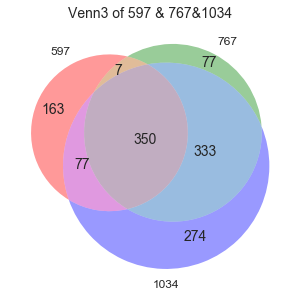

In [71]:
Folder_Name='/venn3'
RAW_PATH = os.getcwd() +  Folder_Name
OUT_PATH = os.getcwd() + Folder_Name
#
#Generate_Venn_Diagram(RAW_PATH, OUT_PATH)
from pybedtools import BedTool
#from pybedtools import scripts.venn_mpl
import pybedtools
from matplotlib_venn import venn3
Raw_Path=RAW_PATH

INPUT_LIST = [f for f in os.listdir(Raw_Path) if not f.startswith('.')]  ## Exclude hidden file, start with .
print INPUT_LIST
if len(INPUT_LIST) == 3:
    print ('Input Three, Continue.')
    PATH_1 = Raw_Path + '/' +INPUT_LIST[0]
    ConA=INPUT_LIST[0][:-4]
    
    PATH_2 = Raw_Path + '/' +INPUT_LIST[1]
    ConB=INPUT_LIST[1][:-4]
    
    PATH_3 = Raw_Path + '/' +INPUT_LIST[2]
    ConC=INPUT_LIST[2][:-4]
    
df1 = BedTool(PATH_1)
df2 = BedTool(PATH_2)
df3 = BedTool(PATH_3)

#out = venn3( subsets = (1, 1, 2, 2, 2, 2, 3), 
#                set_labels = (6,6,6))
#len(df1+df2+df3)
#len(df2+df2+df3)
#union_123=df1.cat(df2.cat(df3, postmerge=False), postmerge=False)
#union_123.sort().merge().count()
merge_123 = df1.cat(df2.cat(df3))
merge_123_with_counts=merge_123.intersect(df1,c=True).intersect(df2,c=True).intersect(df3,c=True)
#merge_123_with_counts.head()

df_merge = pd.read_table(merge_123_with_counts.fn,sep="\t", header=None,
    names= ['#Chr', 'TSS','TES', ConA, ConB, ConC])


A_Sum=df_merge[ConA].sum()
B_Sum=df_merge[ConB].sum()
C_Sum=df_merge[ConC].sum()

df_merge.loc[df_merge.index[df_merge[ConA]>1], [ConA]]=1
df_merge.loc[df_merge.index[df_merge[ConB]>1], [ConB]]=1
df_merge.loc[df_merge.index[df_merge[ConC]>1], [ConC]]=1

df_merge['ABC']=df_merge[ConA]+df_merge[ConB]+df_merge[ConC]
df_merge['AB']=df_merge[ConA]+df_merge[ConB]
df_merge['BC']=df_merge[ConB]+df_merge[ConC]
df_merge['AC']=df_merge[ConA]+df_merge[ConC]

center=df_merge['ABC'].value_counts()[3]
AB_com=df_merge['AB'].value_counts()[2]-center
AC_com=df_merge['AC'].value_counts()[2]-center
BC_com=df_merge['BC'].value_counts()[2]-center


A_solo=A_Sum-AB_com-AC_com-center
B_solo=B_Sum-AB_com-BC_com-center
C_solo=C_Sum-AC_com-BC_com-center

plt.figure(figsize=(5,5))

out=venn3(subsets = (A_solo, B_solo, AB_com, C_solo, AC_com, BC_com,center), \
set_labels = (len(df1),len(df2),len(df3)))

for text in out.subset_labels:
        text.set_fontsize(14)
plt.title('Venn3 of '+str(len(df1))+' & '+ str( len(df2)) +'&' + str( len(df3)),fontsize=14 )
plt.show()



'13449_ctrl_CD8_K27Ac_Gateway_SuperEnhancers'

Input Two, Continue.


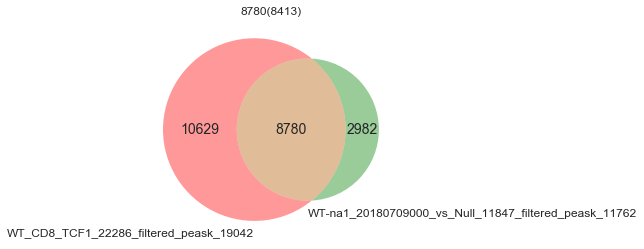

In [10]:
from pybedtools import BedTool
from matplotlib_venn import venn2

Folder_Name='/CD8_Tcf1_ChIP_seq_Peaks'
RAW_PATH = os.getcwd() +  Folder_Name
OUT_PATH = os.getcwd() + Folder_Name
#
INPUT_LIST = os.listdir(RAW_PATH)

if len(INPUT_LIST) == 3:
    print ('Input Two, Continue.')
    PATH_A = RAW_PATH + '/' +INPUT_LIST[0]
    PATH_B = RAW_PATH + '/' +INPUT_LIST[1]

df1 = BedTool(PATH_A)
df2 = BedTool(PATH_B)


intersect_df = df1.intersect(df2, u=True)

out = venn2(subsets=(len(df1-df2), len(df2-df1), len(df2+df1)),
          set_labels=(INPUT_LIST[0][7:-4], INPUT_LIST[1][7:-4]))
for text in out.subset_labels:
    text.set_fontsize(14)


plt.title(str(len(df2+df1))+'('+ str( len(df1+df2)) +')' )
plt.show()
#(df1+df2).saveas(str(len(df1+df2))+'_intersection_'+NAME1[1:-4]+'_'+NAME2[1:-4]+'.bed')
#(df2+df1).saveas(str(len(df2+df1))+'_intersection_'+NAME2[1:-4]+'_'+NAME1[1:-4]+'.bed')
#(df3+(df2+df1)).saveas(str(len(df3+(df2+df1)))+'_genelist_intersection_'+NAME2[1:-4]+'_'+NAME1[1:-4]+'.bed')

In [2]:
import glob
#Folder_Name='/RPKM'
RAW_PATH = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/RPKM/'
#os.chdir(RAW_PATH)#
INPUT_LIST = os.listdir(RAW_PATH)
RPKM_Set=glob.glob(RAW_PATH+'RPKM*.csv')
#RPKM_Set
len(RAW_PATH)

76

In [3]:
df=pd.DataFrame(columns=['gene_id'])
for x in RPKM_Set:
    #print x[16:-68]
    df_tem=pd.read_csv(x,sep='\t').rename(columns={'RPKM':x[76:-68]})
    df=df.merge(df_tem, on='gene_id',how='outer')
df_ALL_DEGs=df.set_index('gene_id')

# heatmap

# PCA



## Input a DataFrame then plot.

In [6]:
# PCA
df_2 = Heatmap_Df #.reset_index()

#### Remove unicode of list in python 
df2_gene_id = [x.encode('ascii', 'ignore') for x in df_2.index]


from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler

#### In here we set targets as the name of columns, which means our purpose is to compare \
#### the relationship between different columns.
targets= [x.encode('ascii', 'ignore') for x in df_2.columns]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

################################################################################

df_2_T = df_2.transpose()

# Separating out the features
x = df_2_T.loc[ :, df2_gene_id ].values


# Separating out the target
y = df_2_T.loc[targets,:].values


# Standardizing the featuresbio
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2', 'PC3','PC4','PC5'] )


########### THIS is fucking killing me. reindex df with df2, just using following command.
principalDf.index = df_2_T.index

#finalDf = pd.concat( [principalDf, df_2_T.loc['target']], axis = 1)
principalDf=principalDf.sort_index()
targets= [x.encode('ascii', 'ignore') for x in principalDf.index]

colors=[]
for i in range(len(targets)):
    colors.append( "C"+ str(i))
    #print(colors[i])

print "PCA Number of Components:" + str(pca.n_components_) 
print "PCA Explained Variance Ratio: " + str(pca.explained_variance_ratio_)  


PCA Number of Components:5
PCA Explained Variance Ratio: [0.49677638 0.10506313 0.07366692 0.0536994  0.03331226]


'[0.49677638 0.10506313]'

(36818, 20)

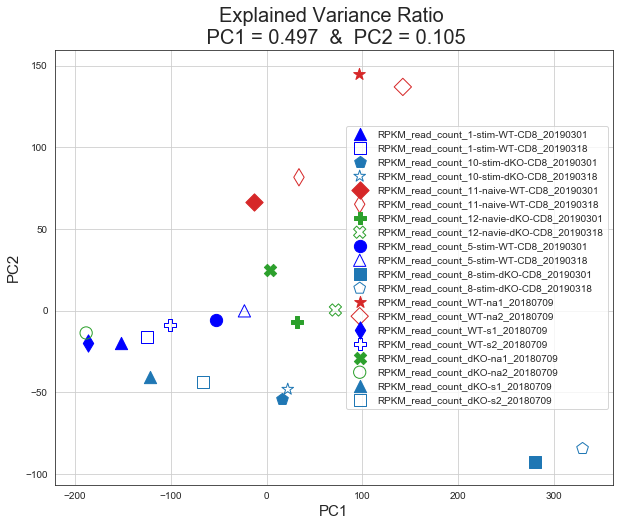

In [30]:
### PLOT
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('Explained Variance Ratio \n PC1 = ' + str(round(pca.explained_variance_ratio_[0],3))+
             '  &  PC2 = '+str(round(pca.explained_variance_ratio_[1],3)), fontsize = 20)

#WT-na Red C3 DKO-na Green C2 WT-s Blue C9  DKO-s Navy C0

colors = ['b','b','C0','C0',
          'C3','C3','C2','C2',
          'b','b','C0','C0',
          'C3','C3','b','b',
          'C2','C2','C0','C0']

i=0
filled_markers = ('o', '^', 's', 'p', '*', 'D', 'd', 'P', 'X')


for target, color in zip( targets,colors):
    indicesToKeep = principalDf.index == target
    i+=1
    order_replicates=i%(len(filled_markers))
    if (i%2 == 0):
        ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , s = 150, edgecolor=color, facecolor='none', marker=filled_markers[order_replicates])
    else:
        ax.scatter(principalDf.loc[indicesToKeep, 'PC1']
               , principalDf.loc[indicesToKeep, 'PC2']
               , s = 150, c=color,marker=filled_markers[order_replicates])
    
ax.legend(targets)
#ax.set_xlim(-2,8)
ax.grid()
Parameters_Detail='CD8_HP'
fig.savefig('PCA'+Parameters_Detail+'.png')
df_ALL_DEGs.shape

## Violin Plot

In [12]:
os.listdir(data_path)

['.ipynb_checkpoints',
 'Only_genelist_306_Newly_acquired_peaks_fc_4.0.bed',
 'Plot_PCA_Heatmap_Violin_venn_scattering.ipynb',
 'Only_genelist_537_lost_peaks_fc_4.0.bed',
 'WT_72h_vs_WT_0h_Expression.txt']

In [24]:
#pwd
import re
PATH_FOLDER=os.getcwd()
data_path = PATH_FOLDER
os.listdir(data_path)

NAME_1 ='/Only_genelist_306_Newly_acquired_peaks_fc_4.0.bed'
NAME_2 ='/Only_genelist_537_lost_peaks_fc_4.0.bed'

df1= pd.read_csv(data_path+NAME_1, sep='\t')
df2= pd.read_csv(data_path+NAME_2, sep='\t')
df_expression = pd.read_csv(data_path+'/WT_72h_vs_WT_0h_Expression.txt', sep='\t')


df_expression['fold_change'] = df_expression['WT_72h_']/df_expression['WT_0h_']
df1 = df1.merge(df_expression[['gene_id','fold_change']], on='gene_id',how='inner').replace([np.inf, -np.inf], np.nan).dropna(axis=0)
df2 = df2.merge(df_expression[['gene_id','fold_change']], on='gene_id',how='inner').replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [ ]:
df_ALL_DEGs = union_all.loc[union_all.index.isin(Tcf1_WT_na1_peak['gene_id'])][['WT-na1', 'dKO-na1']]

# Violin comparison between two data

P_value is: 1.8e-02


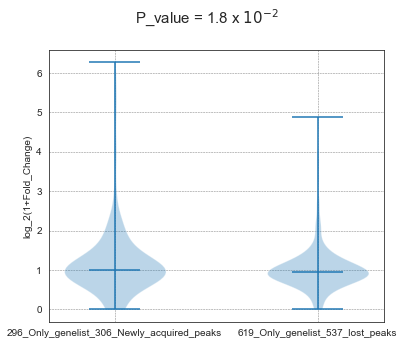

In [37]:
all_data=[np.log2(1+df1['fold_change']), np.log2(1+ df2['fold_change'])]

y_max, y_min = (max( [max(x)  for x in all_data ]), min( [min(x)  for x in all_data ]))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))
axes.violinplot( all_data,showmeans=False,showmedians=True)
axes.grid(color='grey', linestyle='dashed', linewidth=0.5)

axes.set_ylabel('log_2(1+Fold_Change)')


plt.setp( axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=[ str(len(all_data[0]))+'_'+NAME_1[1:-11], str(len(all_data[1]))+'_'+NAME_2[1:-11]])



from scipy import stats
MWU, pvalue = ( stats.mannwhitneyu(all_data[0], all_data[1], alternative=None )[0], 
                stats.mannwhitneyu(all_data[0], all_data[1], alternative='two-sided')[1])
#print "U= %d p = %.1e" % (MWU, pvalue)

if float("%.1e" % pvalue) == 1.0:
    plt.text(0.1, r'p = 1.0', fontsize=15)
    print('P_value is: %.1e' % pvalue )
else:
    if pvalue !=0:
        sign = '='
        digit, exp = re.search(r'(\S+)e(\S+)' , '%.1e' % pvalue).group(1,2)
        print('P_value is: %.1e' % pvalue )
        plt.text( 1.1, (y_max+1.0) , r'P_value {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)
    else:
        sign, digit, exp = '<', '1.0', '-300'
        print('P_value is: %.1e' % pvalue )
        plt.text( 1.1, (y_max+1.0) , r'P_value {} {} x $10^{{{}}}$'.format(sign, digit, int(exp)), fontsize=15)

In [ ]:
df0_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Only_Foxp3_5k.csv', sep='\t', header=0)
df0_a = df0_a.set_index('gene_id').dropna(axis=0, how='any')
df0_a = df0_a.loc[ (df0_a['RPKM'] > 0 ) ]
df0_a = df0_a.rename(columns={'RPKM':'RPKM_WT_Only_Foxp3'})

df0_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Only_Foxp3_5k.csv', sep='\t', header=0)
df0_b = df0_b.set_index('gene_id').dropna(axis=0, how='any')
df0_b = df0_b.loc[ (df0_b['RPKM'] > 0 ) ]
df0_b = df0_b.rename(columns={'RPKM':'RPKM_KO_Only_Foxp3'})

###################################################################################################################
df1_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Intersection_Foxp3_5k_Treg_TCF1.csv', sep='\t', header=0)
df1_a = df1_a.set_index('gene_id').dropna(axis=0, how='any')
df1_a = df1_a.loc[ (df1_a['RPKM'] > 0 ) ]
df1_a = df1_a.rename(columns={'RPKM':'RPKM_WT_Intersection'})

df1_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Intersection_Foxp3_5k_Treg_TCF1.csv', sep='\t', header=0)
df1_b = df1_b.set_index('gene_id').dropna(axis=0, how='any')
df1_b = df1_b.loc[ (df1_b['RPKM'] > 0 ) ]
df1_b = df1_b.rename(columns={'RPKM':'RPKM_KO_Intersection'})

###################################################################################################################
df2_a = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_CD4_TCF1_20160827000_genelist_Only_Treg_TCF1.csv', sep='\t', header=0)
df2_a = df2_a.set_index('gene_id').dropna(axis=0, how='any')
df2_a = df2_a.loc[ (df2_a['RPKM'] > 0 ) ]
df2_a = df2_a.rename(columns={'RPKM':'RPKM_WT_Only_Treg'})

df2_b = pd.read_csv(PATH_FOLDER+'RPKM_genes_read_count_Sample_TKOCD4_TCF1_20160827000_genelist_Only_Treg_TCF1.csv', sep='\t', header=0)
df2_b = df2_b.set_index('gene_id').dropna(axis=0, how='any')
df2_b = df2_b.loc[ (df2_b['RPKM'] > 0 ) ]
df2_b = df2_b.rename(columns={'RPKM':'RPKM_KO_Only_Treg'})

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 8))

axes[0,0].violinplot(  (np.log10(df0_a.iloc[:,0])),showmeans=False,showmedians=True )
axes[0,0].set_title('gene_list_WT_Only_FoxP3_'+str(len(df0_a)))

axes[1,0].violinplot( ( np.log10(df0_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,0].set_title('gene_list_KO_Only_FoxP3_'+str(len(df0_b)))



axes[0,1].violinplot( ( np.log10(df1_a.iloc[:,0] )),showmeans=False,showmedians=True)
axes[0,1].set_title('gene_list_WT_Intersection_'+str(len(df1_a)))

axes[1,1].violinplot( ( np.log10(df1_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,1].set_title('gene_list_KO_Intersection_'+str(len(df1_b)))



axes[0,2].violinplot( ( np.log10(df2_a.iloc[:,0] )),showmeans=False,showmedians=True)
axes[0,2].set_title('gene_list_WT_Only_Treg_'+str(len(df2_a)))

axes[1,2].violinplot( ( np.log10(df2_b.iloc[:,0] )),showmeans=False,showmedians=True)
axes[1,2].set_title('gene_list_KO_Only_Treg_'+str(len(df2_b)))



for i in range(2):
    for j in range(3):
        ax=axes[i,j]
        ax.yaxis.grid(True)
        #ax.set_xticks([y + 1 for y in range(max(df1))])
        ax.set_ylim(-0.5,2)
        ax.set_xlabel('Frequency')
        ax.set_ylabel('log10(RPKM)')

fig.savefig('gene_list_WT_KO.png') 

# Scattering Plot + Heatmap

In [40]:
def hexbin_with_density(df, highlight_name, title_name, density_scale, drop_top_outlier):
    ### drop outlier
    df = df.drop(df_all_tem.iloc[:,0].nlargest(n=drop_top_outlier,keep='first').index)
    
    
    range_limit=df.max().max()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9), sharex=False, sharey=False)
    
    if density_scale == 'log':
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   bins='log',mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Log$_{10}$(1+Counts)', fontsize=18)
    else:
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Counts', fontsize=18)

    ###  highlight a point
    if len(highlight_name) >= 1:
        for highlight_index in highlight_name[:]:
            ax.scatter(df[df.index == highlight_index].iloc[:,[0]],
                        df[df.index == highlight_index].iloc[:,[1]],
                        alpha=1.0,s=50,color='red', label=highlight_index,edgecolor='red')
            ax.text(df[df.index == highlight_index].iloc[:,0]-range_limit/20.0,
                      df[df.index == highlight_index].iloc[:,1]+range_limit/25.0, highlight_index, fontsize=16, color='r')


    ax.yaxis.grid(False)
    ax.set_ylim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlabel(str(df.columns[0]), fontsize=18)
    ax.set_ylabel(str(df.columns[1]), fontsize=18)
    ax.plot([-0.1*range_limit,range_limit+0.1*range_limit], [-0.1*range_limit, range_limit+0.1*range_limit], ls="--", c="gray")
    ax.set_title(str(len(df))+ ': '+ title_name , fontsize=18)
    return 0

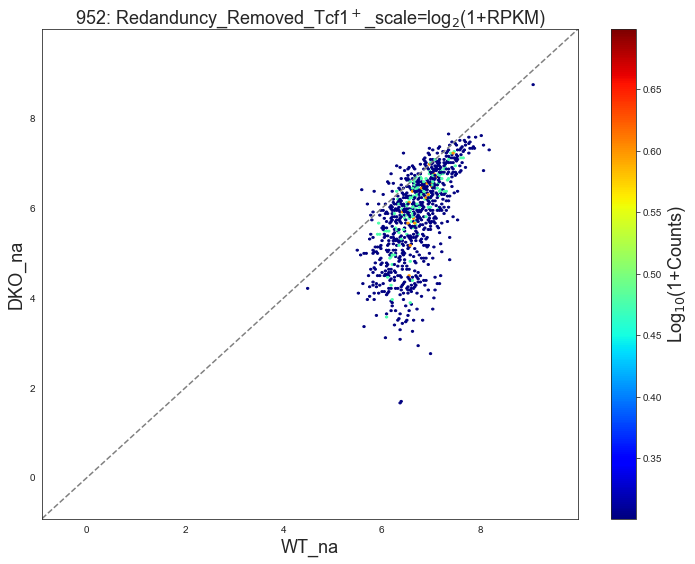

In [52]:
### Union Peaks 26310
#FOLDER_PATH = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/RPKM/redanduncy_removed_results/'
FOLDER_PATH = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/RPKM/'
df_DNase = pd.DataFrame(columns=['gene_id'])
df_DNase_WT_na = pd.read_csv(FOLDER_PATH+'RPKM_read_count_WT-na_20180709000_952_Tcf1_motif_Plus_Union_WT-na_dKO-na.csv', sep='\t' )
df_DNase = df_DNase.merge(df_DNase_WT_na, on='gene_id',how='outer').rename(columns={'RPKM':'WT_na'})
df_DNase_DKO_na = pd.read_csv(FOLDER_PATH+'RPKM_read_count_dKO-na_20180709000_952_Tcf1_motif_Plus_Union_WT-na_dKO-na.csv', sep='\t' )
df_DNase = df_DNase.merge(df_DNase_DKO_na, on='gene_id',how='inner').rename(columns={'RPKM':'DKO_na'}).set_index('gene_id')
df_DNase['DKO_na'] = df_DNase['DKO_na'] #*(46.297627/26.481140)



df_all_tem = pd.DataFrame({'WT_na': np.log2(1+df_DNase['WT_na']), 'DKO_na':  np.log2(1+df_DNase['DKO_na'])}, index=df_DNase.index)
df_all_tem = df_all_tem[['WT_na', 'DKO_na']]
aa = hexbin_with_density(df_all_tem,'', 'Redanduncy_Removed_Tcf1$^+$_scale=log$_2$(1+RPKM)', 'log',0)


0

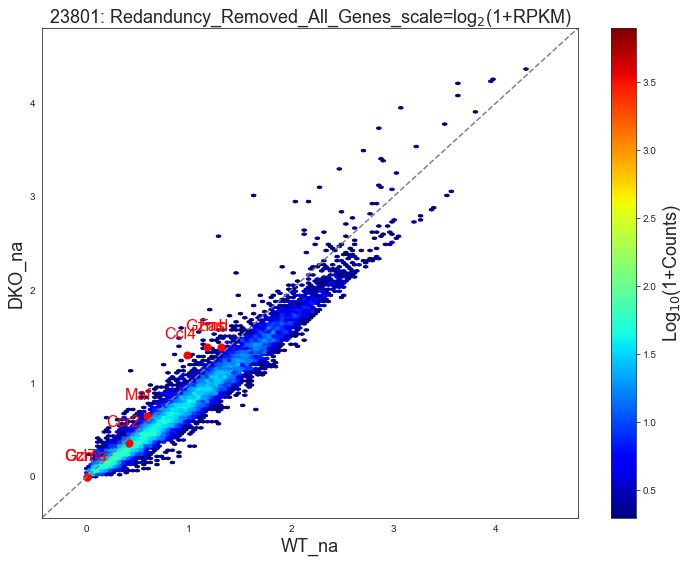

In [49]:
### all ex 50k TSS genes
FOLDER_PATH = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/RPKM/redanduncy_removed_results/'
#FOLDER_PATH = '/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/RPKM/'

df_DNase = pd.DataFrame(columns=['gene_id'])
df_DNase_WT_na = pd.read_csv(FOLDER_PATH+'RPKM_read_count_WT-na_20180709000_gene_Genebody_Up_EX_50k_unique.csv', sep='\t' )
df_DNase = df_DNase.merge(df_DNase_WT_na, on='gene_id',how='outer').rename(columns={'RPKM':'WT_na'})
df_DNase_DKO_na = pd.read_csv(FOLDER_PATH+'RPKM_read_count_dKO-na_20180709000_gene_Genebody_Up_EX_50k_unique.csv', sep='\t' )
df_DNase = df_DNase.merge(df_DNase_DKO_na, on='gene_id',how='inner').rename(columns={'RPKM':'DKO_na'}).set_index('gene_id')
df_DNase['DKO_na'] = df_DNase['DKO_na'] #*(46.297627/26.481140)

genelist=['Ccl4','Ccl7','Ccr2','Fasl','Gzma','Gzmb','Maf']

df_all_tem = pd.DataFrame({'WT_na': np.log2(1+df_DNase['WT_na']), 'DKO_na':  np.log2(1+df_DNase['DKO_na'])}, index=df_DNase.index)
df_all_tem = df_all_tem[['WT_na', 'DKO_na']]
hexbin_with_density(df_all_tem, genelist, 'Redanduncy_Removed_All_Genes_scale=log$_2$(1+RPKM)','log',9)

# Profile


In [28]:
def Get_GeneBody_Profile(INPUT_read_file, INPUT_gtf_file, Feature_Type_Used, INPUT_gene_list, genic_partition, fragment_size):
    ## Read Reads_File, and distribute them into GenomicArray.
    import HTSeq
    import numpy
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="i")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    for alt in bedfile:
        if alt.iv.strand == "+":
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d + fragment_size / 2)
        elif alt.iv.strand == "-":
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d - fragment_size / 2)
        ga[alt_pos] += 1
        num_reads += 1
##########################################################################################
    ## Read gtf_file
    gtffile = HTSeq.GFF_Reader(INPUT_gtf_file)
##########################################################################################    
    ## Read Gene_list_file
    gene_list = pd.read_csv(INPUT_gene_list, header=None, sep='\s+', usecols=[3])[3].str.strip()
    gene_list_unique=gene_list.unique()
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_iv_set = set()
    
    gff_feature_type_for_profile = Feature_Type_Used

    for feature in gtffile:
        if feature.type == Feature_Type_Used and feature.attr["gene_id"] in gene_list_unique:
            site_iv_set.add(feature.iv)
    
    profile = numpy.zeros(genic_partition)
    Num_Skip = 0
    for site_iv in site_iv_set:
        partition_size =site_iv.length / (1.0*genic_partition) ## Prevent int division
        if(partition_size < 1):
            Num_Skip +=1 
            continue
##########################################################################################
        index = 0
        for site_pos in site_iv.xrange_d(partition_size):
            count_in_window = 0
            if site_pos.strand == "+":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos, site_pos.pos + partition_size)
            elif site_pos.strand == "-":
                site_pos_window_iv = HTSeq.GenomicInterval(site_pos.chrom, site_pos.pos - partition_size + 1,
                                                           site_pos.pos + 1)

            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile[index] += count_in_window / (1.0*partition_size)
            index += 1
            if index >= genic_partition:
                break
    
    print "...................................................."
    print "Profile on: TSS_GeneBody_TES "
    print "Number of transcripts: %i" % len(site_iv_set)
    print "Number of reads: %i" % num_reads 
    print "...................................................."
    print ("Total Number of Skipped gene_list: "+str(Num_Skip))
    print ("Because their length are less than your choose genic_partition")
        
    return  (profile*(10**9)/(num_reads*(len(site_iv_set)-Num_Skip)))


def Get_Bed_Region_Profile(INPUT_read_file, INPUT_gene_list, genic_partition,fragment_size):
    ## Read Reads_File, and distribute them into GenomicArray.
    ## Region
    import HTSeq
    import numpy
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="i")
    ### WT-na
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    ### WT-na
    for alt in bedfile:
        if alt.iv.strand == "+":
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d + fragment_size / 2)
        elif alt.iv.strand == "-":
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d - fragment_size / 2)
        elif alt.iv.strand =="." :
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start_d + alt.iv.end_d)/2 )
        ga[alt_pos] += 1
        num_reads += 1
    ### After above for loop, we have location information of all input reads summit. 

    ##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    region_bedfile = HTSeq.BED_Reader(INPUT_gene_list)
    ga_region_from_bedfile=set()### Only ga has feature 
    # These methods yield iterators of :class:GenomicPosition objects from start to end (or, for xrange_d from start_d to end_d).

    profile = numpy.zeros(genic_partition)  ### | | | | | |   5 partitions but only four sites for profile.
    Num_Skip = 0
    for site in region_bedfile:
        ga_region_from_bedfile.add(site.iv)
    ##########################################################################################
    ##########################################################################################
    for site_ga in ga_region_from_bedfile:
        index = 0
        i=0
        partition_size = site_ga.length / (1.0*genic_partition) ## Prevent int division
        for site in site_ga.xrange_d(partition_size):
            if (i==0):
                i+=1
                continue
            count_in_window = 0
            if site.strand=="+":
                print "+"
                #site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos, site.pos + partition_size) 
            elif site.strand=="-":
                print "-"
                #site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos - partition_size +1, site.pos + 1) 
            elif site.strand==".":
                site_pos_window_iv = HTSeq.GenomicInterval(site.chrom, site.pos - partition_size, site.pos + partition_size) 
            for step_iv, step_count in ga[site_pos_window_iv].steps():
                count_in_window += step_count * step_iv.length
            profile[index] += count_in_window / (2.0*partition_size)
            index += 1
            if index >= genic_partition:
                break

    norm_profile = (profile*(10**9)/(num_reads*(len(ga_region_from_bedfile)-Num_Skip)))
    return norm_profile

In [4]:
def Get_Site_Profile(INPUT_read_file, INPUT_gtf_file, Feature_Type_Used, INPUT_gene_list, site_name, window_size, fragment_size, resolution, upstreamExtension,downstreamExtension):
    ## Read Reads_File, and distribute them into GenomicArray.
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="i")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    for alt in bedfile:
        if alt.iv.strand == "+":
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d + fragment_size / 2)
        elif alt.iv.strand == "-":
            alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, alt.iv.start_d - fragment_size / 2)
        ga[alt_pos] += 1
        num_reads += 1
##########################################################################################
    ## Read gtf_file
    gtffile = HTSeq.GFF_Reader(INPUT_gtf_file)
##########################################################################################    
    ## Read Gene_list_file
    gene_list = pd.read_csv(INPUT_gene_list, header=None, sep='\s+', usecols=[3])[3].str.strip()
    gene_list_unique=gene_list.unique()
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_pos_set = set()
    
    if (site_name=='TSS'):
        for feature in gtffile:
            if feature.type == Feature_Type_Used and feature.attr["gene_id"] in gene_list_unique:
                site_pos_set.add(feature.iv.start_d_as_pos)
    elif(site_name=='TES'):
        for feature in gtffile:
            if feature.type == Feature_Type_Used and feature.attr["gene_id"] in gene_list_unique:
                site_pos_set.add(feature.iv.end_d_as_pos)
    else:
        print("ERROR: Default is TSS or TES, your input is neither!")
    
    
    ### Set up number of points
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
    
    profile = numpy.zeros(total_num_points)
    
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2)
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)

                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    
    print "...................................................."
    print "Profile on: %s " % site_name
    print "Number of transcripts: %i" % len(site_pos_set)
    print "Number of reads: %i" % num_reads 
    normalization_facotr = num_reads*len(site_pos_set)
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

In [6]:
### The Core Feature Area should takes around 1/3 of the total region. 
## To avoid over-smooth processing, the window size extension should be strictly less than half of the whole Plot region.
def Get_Summit_Profile(INPUT_read_file, INPUT_bed_file, resolution, window_size, upstreamExtension, downstreamExtension):
    ## Read Reads_File, and distribute them into GenomicArray.
    import HTSeq
    import numpy
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    num_reads = 0
    for alngt in bedfile:
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1
##########################################################################################
    middle_point=False
    if middle_point:
        for alt in bedfile:
            if alt.iv.strand == "-":
                alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start_d + alt.iv.end_d) / 2)
            else:
                alt_pos = HTSeq.GenomicPosition(alt.iv.chrom, (alt.iv.start_d + alt.iv.end_d) / 2)
            ga[alt_pos] += 1
            num_reads += 1
##########################################################################################
    ## Read peak file
    peakfile = HTSeq.BED_Reader(INPUT_bed_file)
##########################################################################################    
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_pos_set = set()
    
    for feature in peakfile:
        site_pos_set.add(HTSeq.GenomicPosition(feature.iv.chrom, (feature.iv.start_d + feature.iv.end_d)/2,feature.iv.strand))
    print "Number of Profiles Being Averaged : %i" % len(site_pos_set)
        
    ### Set up number of points
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
    
    profile = numpy.zeros(total_num_points)
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2)
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)
                else:
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    if (index_pos - window_size / 2) < 0:
                        index += 1
                        continue
                    else:
                        tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2)

                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    
    print "...................................................."
    print "Profile on Sites Summit "
    print "Number of Profiles Being Averaged: %i" % len(site_pos_set)
    print "Number of Sites Being Distributed: %i" % num_reads 
    normalization_facotr = num_reads*len(site_pos_set)
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

### The Core Feature Area should takes around 1/3 of the total region. 

## To avoid over-smooth processing, the window size extension should be strictly less than half of the whole Plot region.
#
def Get_Boundary_Profile(INPUT_read_file, INPUT_bed_file, resolution, window_size, upstreamExtension,downstreamExtension):
    ## Read Reads_File, and distribute them into GenomicArray.
    import HTSeq
    import numpy
    num_reads = 0
    ga = HTSeq.GenomicArray("auto", stranded=False, typecode="d")
    bedfile = HTSeq.BED_Reader(INPUT_read_file)
    num_reads = 0
    for alngt in bedfile:
        ga[alngt.iv] += 1.0/alngt.iv.length
        num_reads+=1

##########################################################################################
    ## Read Trascritps file
    peakfile = HTSeq.BED_Reader(INPUT_bed_file)
##########################################################################################    
##########################################################################################
    ### To calculate the number of transcripts that for profile plot.
    ### And also store position in a set.
    site_pos_set = set()
    
    for feature in peakfile:
        site_pos_set.add(HTSeq.GenomicPosition(feature.iv.chrom, feature.iv.start+2, feature.iv.strand))
        site_pos_set.add(HTSeq.GenomicPosition(feature.iv.chrom, feature.iv.end+1, feature.iv.strand))
    
    print "Number of Profiles Being Averaged: %i" % len(site_pos_set)    
    ### Set up number of points
    upstream_num_points = upstreamExtension / resolution
    downstream_num_points = downstreamExtension / resolution
    total_num_points = upstream_num_points + downstream_num_points + 1
    
    profile = numpy.zeros(total_num_points)
    for tss_pos in site_pos_set:
            index = 0
            while index < total_num_points:
                count_in_window = 0
                if tss_pos.strand == "+":
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2, index_pos + window_size / 2)
                elif tss_pos.strand == "-":
                    index_pos = tss_pos.pos - (index - upstream_num_points) * resolution
                    tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 + 1, index_pos + window_size / 2 + 1)
                else:
                    index_pos = tss_pos.pos + (index - upstream_num_points) * resolution
                    if (index_pos - window_size / 2) < 0:
                        index += 1
                        continue
                    else:
                        tss_pos_window_iv = HTSeq.GenomicInterval(tss_pos.chrom, index_pos - window_size / 2 , index_pos + window_size / 2)

                for step_iv, step_count in ga[tss_pos_window_iv].steps():
                    count_in_window += step_count * step_iv.length
                ###gives average read count for position
                profile[index] += count_in_window / (1.0*window_size)
                index += 1
    
    print "...................................................."
    print "Profile on Sites Boundaries Summit "
    print "Number of Profiles Being Averaged: %i" % len(site_pos_set)
    print "Number of Sites Being Distributed: %i" % num_reads 
    normalization_facotr = num_reads*len(site_pos_set)
    return  (profile*(10**9)/(num_reads*len(site_pos_set)))

....................................................
Profile on: TSS_GeneBody_TES 
....................................................
Because their length are less than your choose genic_partition


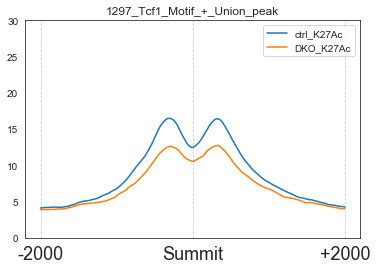

In [27]:
print "...................................................."
print "Profile on: TSS_GeneBody_TES "
#print "Number of transcripts: %i" % len(ga_region_from_bedfile)
#print "Number of reads: %i" % num_reads 
print "...................................................."
#print ("Total Number of Skipped gene_list: "+str(Num_Skip))
print ("Because their length are less than your choose genic_partition")


### Plot     
fig, ax=plt.subplots(1,1)

#ax.plot(np.arange(-(num_profile_points)/2,(num_profile_points)/2), norm_profile1[0:num_profile_points], label='ctrl_K27Ac')
#ax.plot(np.arange(-(num_profile_points)/2,(num_profile_points)/2), norm_profile3[0:num_profile_points], label='DKO_K27Ac')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile2[0:num_profile_points], label='ctrl_K27Ac')
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile4[0:num_profile_points], label='DKO_K27Ac')

ax.set_title(Name2)
ax.legend()
ax.set_ylim(0,30)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-2000','Summit','+2000']
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')

Number of transcripts: 8508
....................................................
Profile on peak Summit 
Number of transcripts: 8508
Number of reads: 56260
....................................................
....................................................


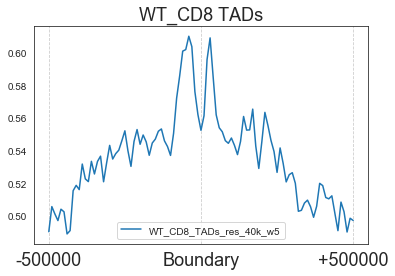

In [48]:
### test reads with test boundary
INPUT_read_file ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/HiC/TopDom_Analysis/CTCF_ChIPseq/MACS2_Results/BAM/SRR5585942_vs_Null_58466_filtered_peask_56260_HTseq.bed"
#INPUT_read_file_2 ="/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/reads_removed_repeats/combine_replicates/dKO-na_CTCF-.bedpe"
#INPUT_read_file ="/home/lxiang/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/DNase_seq/reads_removed_repeats/combine_replicates/WT-na_CTCF+.bedpe"
PATH_FOLDER=os.getcwd() + '/venn2/'


#for input_genelist in INPUT_LIST:
Name1="WT_CD8_TADs_res_40k_w5.bed"
#Name1="WT_CD8_TAD_Domain.bed"
INPUT_gene_list = PATH_FOLDER + Name1

upstreamExtension = 500000
resolution = upstreamExtension/50
window_size = 2*resolution

num_profile_points= 2*upstreamExtension / resolution +1
norm_profile   = Get_Boundary_Profile(INPUT_read_file, INPUT_gene_list, resolution, window_size, upstreamExtension, upstreamExtension)

print "...................................................."
#print "Profile on: TSS_GeneBody_TES "
#print "Number of transcripts: %i" % len(ga_region_from_bedfile)
#print "Number of reads: %i" % num_reads 
print "...................................................."
#print ("Total Number of Skipped gene_list: "+str(Num_Skip))
#print ("Because their length are less than your choose genic_partition")


### Plot     
fig, ax=plt.subplots(1,1)
ax.plot(np.arange(-(num_profile_points-1)/2,(num_profile_points+1)/2), norm_profile[0:num_profile_points], label='WT_CD8_TADs_res_40k_w5')

ax.set_title("WT_CD8 TADs", size=18)

ax.legend()
#ax.set_ylim(0.9,1.7)
x=[-upstreamExtension / resolution,0,upstreamExtension /resolution ]
ax.set_xticks(x)
customized_xticks=['-'+str(upstreamExtension),'Boundary','+'+str(upstreamExtension)]
ax.set_xticklabels(customized_xticks, fontsize=18)
ax.grid(which='major', axis='x', linestyle='--')
ax.set_ylabel('Number of Peaks per 10kb', fontsize=16)